# Проект: Обучение с учителем: качество модели

## Описание проекта

Интернет-магазин «В один клик» предлагает широкий ассортимент товаров: от бытовой техники до продуктов и косметики. В последнее время руководство компании зафиксировало снижение активности постоянных клиентов. Привлекать новых покупателей становится всё дороже, поэтому фокус смещается на **удержание текущих клиентов** с помощью **персонализированных предложений**.

## Цель проекта

Разработать модель, которая будет предсказывать вероятность снижения активности клиента в течении близжайщих трех месяцев. Это позволит:
- выделить группу клиентов с высоким риском потери интереса;
- предложить каждой из них персональзированные маркетинговые решения;
- увеличить общую прибыль компании за счет удержания клиентов.

## Целевая переменная

- **покупательская активность** - категориальный признак:
    -  'Снизилась' - клиент стал покупать меньше;
    - 'Прежний уровень' - активность не изменилась.
    

## Загрузка данных

In [1]:
# устанавливаем дополнительные библиотека
!pip install --upgrade shap

     |████████████████████████████████| 994 kB 1.4 MB/s eta 0:00:01


In [2]:
!pip install seaborn

In [3]:
!pip install scikit-learn==1.1.3 -q

In [4]:
# код ревьюера - чтобы полечить shap
!pip install matplotlib==3.5.2 -q
 


In [5]:
#импорт библиотек
#работа с таблицами
import shap
import pandas as pd
import numpy as np

#визуализация 
import matplotlib.pyplot as plt
import seaborn as sns

#предобработка и трансформация 
from sklearn.preprocessing import (StandardScaler, MinMaxScaler, 
                                   OneHotEncoder, OrdinalEncoder)
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

#разделение выборки и подбор параметров
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV

#модели
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

#метрика
from sklearn.metrics import (
classification_report, confusion_matrix, f1_score, roc_auc_score, accuracy_score,
precision_score, recall_score)

#метод отбора признаков
from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif

from sklearn.inspection import permutation_importance


In [6]:
#загрузка файлов
df_market = pd.read_csv('/datasets/market_file.csv', sep=',', decimal=',')
df_money = pd.read_csv('/datasets/market_money.csv', sep=',', decimal=',')
df_time = pd.read_csv('/datasets/market_time.csv', sep=',', decimal=',')
df_profit = pd.read_csv('/datasets/money.csv', sep=';', decimal=',')

In [7]:
#проверим первые строки
display(df_market.head())
display(df_money.head())
display(df_time.head())
display(df_profit.head())

,id,Покупательская активность,Тип сервиса,Разрешить сообщать,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Популярная_категория,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит
0,215348,Снизилась,премиум,да,3.4,5,121,0.0,Товары для детей,6,2,1,5
1,215349,Снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5
2,215350,Снизилась,стандартт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5
3,215351,Снизилась,стандартт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4
4,215352,Снизилась,стандартт,нет,5.1,3,1064,0.94,Товары для детей,3,2,3,2


,id,Период,Выручка
0,215348,препредыдущий_месяц,0.0
1,215348,текущий_месяц,3293.1
2,215348,предыдущий_месяц,0.0
3,215349,препредыдущий_месяц,4472.0
4,215349,текущий_месяц,4971.6


,id,Период,минут
0,215348,текущий_месяц,14
1,215348,предыдцщий_месяц,13
2,215349,текущий_месяц,10
3,215349,предыдцщий_месяц,12
4,215350,текущий_месяц,13


,id,Прибыль
0,215348,0.98
1,215349,4.16
2,215350,3.13
3,215351,4.87
4,215352,4.21


## Предобработка данных

Проведем необходимую предобработку данных. Найдем дубликаты, пропуски, несоотвтествующие типы данных.

In [8]:
print(df_market.info())
print(df_money.info())
print(df_time.info())
print(df_profit.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 13 columns):
 #   Column                               Non-Null Count  Dtype 
---  ------                               --------------  ----- 
 0   id                                   1300 non-null   int64 
 1   Покупательская активность            1300 non-null   object
 2   Тип сервиса                          1300 non-null   object
 3   Разрешить сообщать                   1300 non-null   object
 4   Маркет_актив_6_мес                   1300 non-null   object
 5   Маркет_актив_тек_мес                 1300 non-null   int64 
 6   Длительность                         1300 non-null   int64 
 7   Акционные_покупки                    1300 non-null   object
 8   Популярная_категория                 1300 non-null   object
 9   Средний_просмотр_категорий_за_визит  1300 non-null   int64 
 10  Неоплаченные_продукты_штук_квартал   1300 non-null   int64 
 11  Ошибка_сервиса                       1300 n

In [9]:
df_market['Маркет_актив_6_мес'] = df_market['Маркет_актив_6_мес'].astype(float)
df_market['Акционные_покупки'] = df_market['Акционные_покупки'].astype(float)

df_money['Выручка'] = df_money['Выручка'].astype(float)

In [10]:
df_time['Период'].unique()

array(['текущий_месяц', 'предыдцщий_месяц'], dtype=object)

In [11]:
df_time['Период'] = df_time['Период'].str.replace('предыдцщий_месяц', 'предыдущий_месяц')
df_time['Период'].unique()

array(['текущий_месяц', 'предыдущий_месяц'], dtype=object)

In [12]:
#проверка на пропуски
print(df_market.isna().sum())
print(df_money.isna().sum())
print(df_time.isna().sum())
print(df_profit.isna().sum())

id                                     0
Покупательская активность              0
Тип сервиса                            0
Разрешить сообщать                     0
Маркет_актив_6_мес                     0
Маркет_актив_тек_мес                   0
Длительность                           0
Акционные_покупки                      0
Популярная_категория                   0
Средний_просмотр_категорий_за_визит    0
Неоплаченные_продукты_штук_квартал     0
Ошибка_сервиса                         0
Страниц_за_визит                       0
dtype: int64
id         0
Период     0
Выручка    0
dtype: int64
id        0
Период    0
минут     0
dtype: int64
id         0
Прибыль    0
dtype: int64


In [13]:
#проверим на дубликаты
dupl_market = df_market[df_market.duplicated()]
dupl_money = df_money[df_money.duplicated()]
dupl_time = df_time[df_time.duplicated()]
dupl_profit = df_profit[df_profit.duplicated()]
print(dupl_market.count())
print(dupl_money.count())
print(dupl_time.count())
print(dupl_profit.count())

id                                     0
Покупательская активность              0
Тип сервиса                            0
Разрешить сообщать                     0
Маркет_актив_6_мес                     0
Маркет_актив_тек_мес                   0
Длительность                           0
Акционные_покупки                      0
Популярная_категория                   0
Средний_просмотр_категорий_за_визит    0
Неоплаченные_продукты_штук_квартал     0
Ошибка_сервиса                         0
Страниц_за_визит                       0
dtype: int64
id         0
Период     0
Выручка    0
dtype: int64
id        0
Период    0
минут     0
dtype: int64
id         0
Прибыль    0
dtype: int64


In [14]:
#проверим на неявные дубликаты 
df_market['Тип сервиса'] = df_market['Тип сервиса'].str.replace('стандартт', 'стандарт')
df_market['Тип сервиса'] = df_market['Тип сервиса'].str.capitalize()
df_market['Разрешить сообщать'] = df_market['Разрешить сообщать'].str.capitalize()
df_market['Тип сервиса'].unique()

array(['Премиум', 'Стандарт'], dtype=object)

In [15]:
#проверим на неявные дубликаты
df_market[df_market.duplicated(subset='id')]

,id,Покупательская активность,Тип сервиса,Разрешить сообщать,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Популярная_категория,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит


In [16]:
for col in df_market.select_dtypes(include='object'):
    print(df_market[col].unique())

['Снизилась' 'Прежний уровень']
['Премиум' 'Стандарт']
['Да' 'Нет']
['Товары для детей' 'Домашний текстиль' 'Косметика и аксесуары'
 'Техника для красоты и здоровья' 'Кухонная посуда'
 'Мелкая бытовая техника и электроника']


#### Проверил данные на пропуски, дубликаты, неявные дубликаты. внес изменения в тип данных ('Маркет_актив_6_мес', 'Акционные_покупки', 'Выручка'), в столбце Тип сервиса нашел неправильно написанное слово и исправил.

## Исследовательский анализ данных
Проведем исследовательский анализ данных из каждой таблицы. Отберем клиентов с покупательской активностью не менее трёх месяцев, то есть таких, которые что-либо покупали в этот период. Оформите выводы по результатам шага

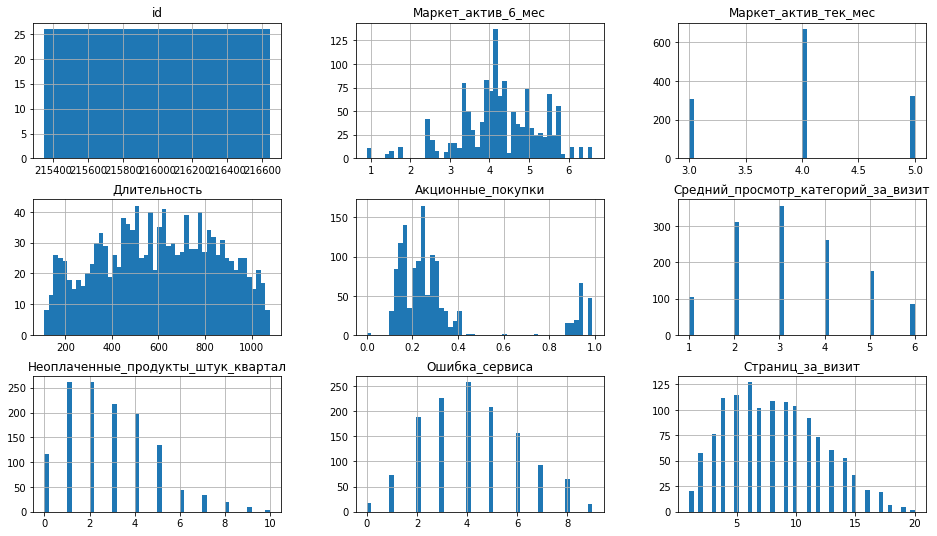

In [17]:
df_market.hist(bins=50, figsize=(16,9));

#### Сравним все признаки с целевым для поиска закономерности, отбросить шумовые признаки, построить гипотезы.

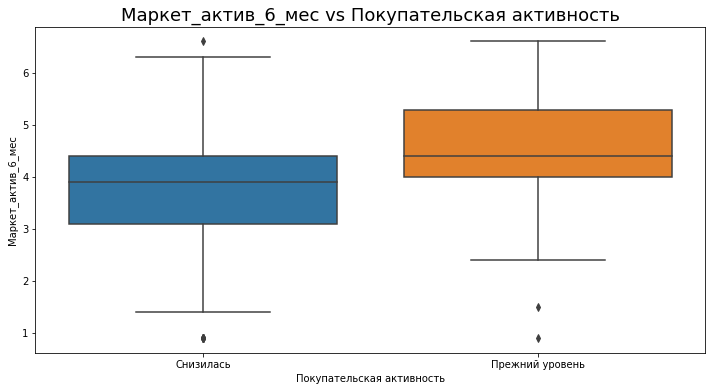

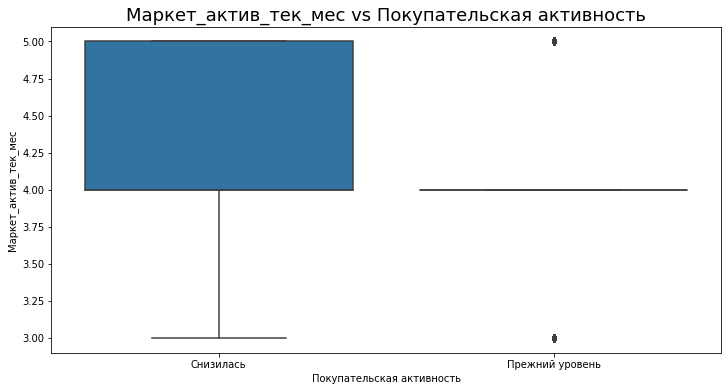

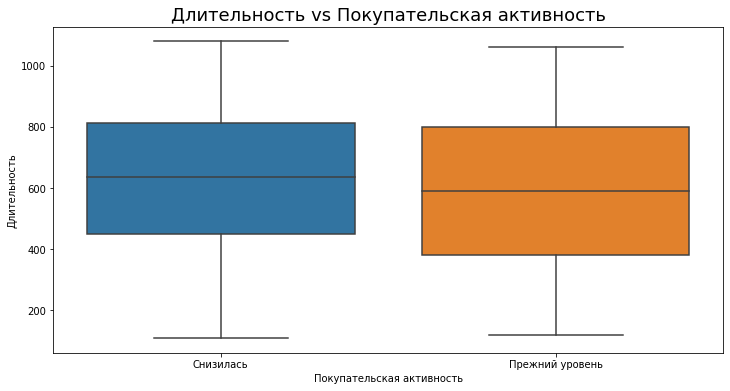

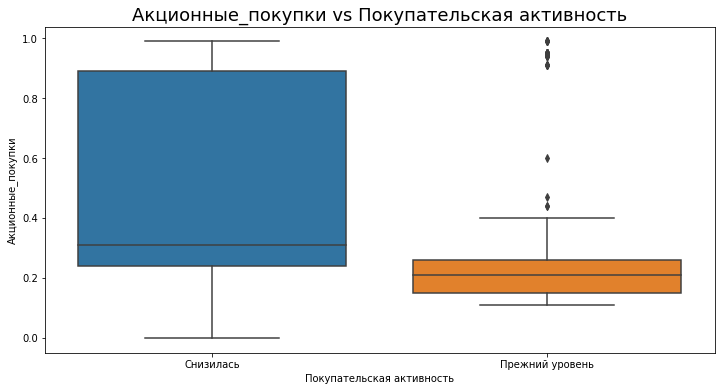

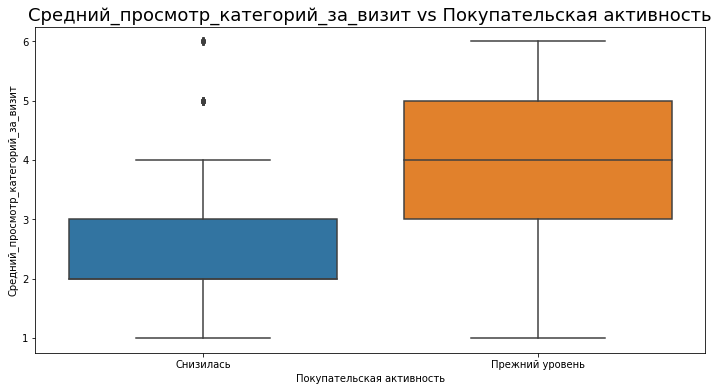

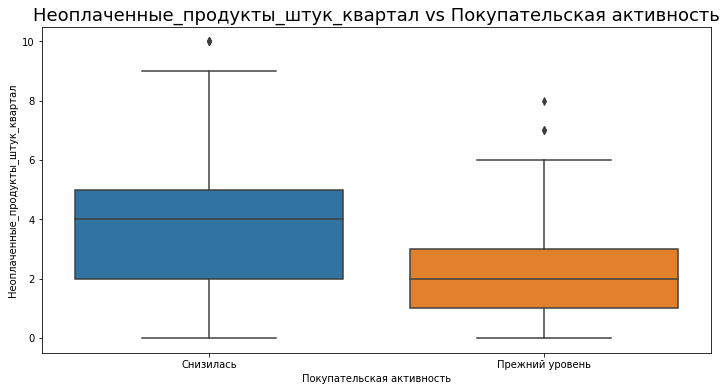

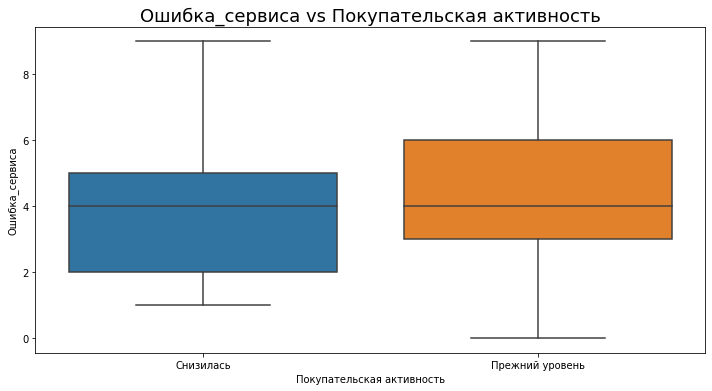

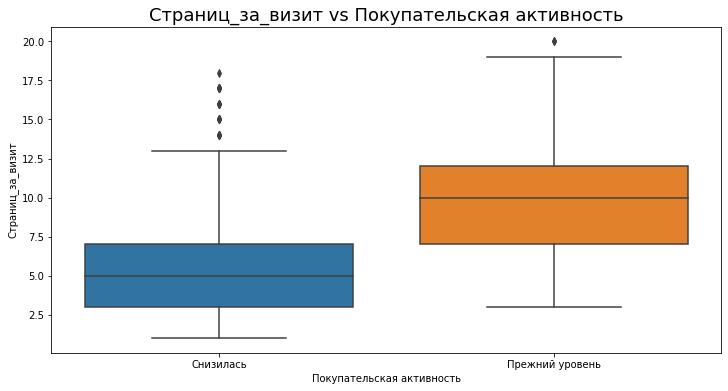

In [18]:
#для всех числовых признаком
for col in df_market.select_dtypes(include=['int64', 'float64']):
    if col != 'id':
        plt.figure(figsize=(12,6))
        sns.boxplot(x='Покупательская активность', y=col, data=df_market)
        plt.title(f'{col} vs Покупательская активность', fontsize=18)
        plt.show()

#### Описание количественных признаков
1. "Маркет_актив_6_мес. vs Покупательская активность - "Прежний уроверь" медиана выше находтся (~4,5), чем медиана "Снизилась" около 3,9. Признак связан с удержанием - при более высокой маркетинговой активности клиент, не снижают активность. **(Признак важен)**

2. 'Маркет_актив_тек_мес' - у клиентов сниженной активнойстью медаина выше - им в среднем больше "надавали маркетинга", но это не сработало. Возможно, меркетинг приходит слишком поздно или неэффективно. **(Признак важен)**

3. "Длительность" - "Снизивщиеся" в среднем клиенты давно зарегистрированы, но снизили активность, а "Прежнеактивные" - наоборот моложе по длительности, но пока удержались. Дольше пользуются - меньше пользуются. **(Признак важный)**

4. "Акционные покупки vs "Покупательская активность" - Пукапательская активность "Снизилась" медиана акционных покупок около 0.3. Разброс огромный: многие покупали исключительно по акции. У клиентов "Прежный уровень" vtmyit медиана 0,2. и редкие покупки от 0.4 до 1.0. Признак демонстрирует сильную связь с оттоком. **(Признак важный)**

5. "Средний_просмотр_категорий_за_визит" - У клиентов "Снизивщиеся" медиана около 2 категории. Есть два выброса 5 и 6, но они реалистичные. у клиентов "Прежнеактивных" медиана около 4 категории за визит. **(Признак важный)**

6. У клиентов "Снизивщиеся" медиана около 4 неоплачен. продуктов в квартале? выбросы 10 , у "Прежнеактивных" медиана около 2 штук в корзине.Есть выбросы 7 и 8 - и такое тоже бывает.**(Признак важный)**

7. У клиентов "Снизкоактивностью" медиана около 4 ошибок сервиса, также и у клиентов "Прежнеактивных" **(Признак важный)**

8. E клиентов "Прежнеактивных" значительно выше медиана около 10 страниц за визит. у клиентов "Снизкоактивных" медиана 5. **(Важный признак)**

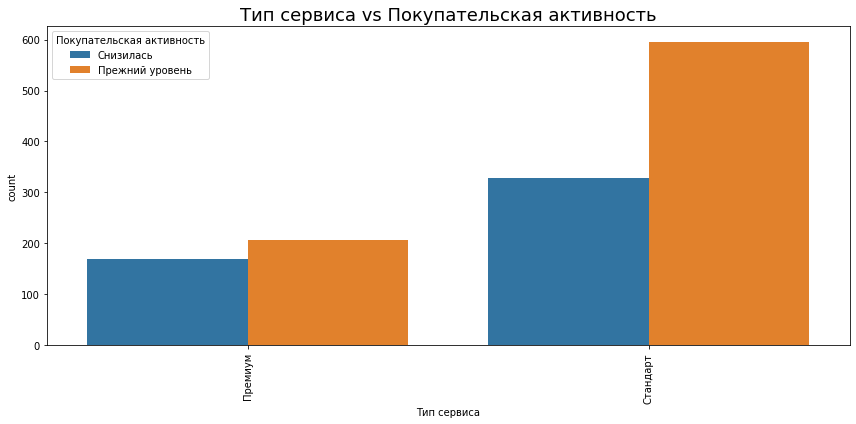

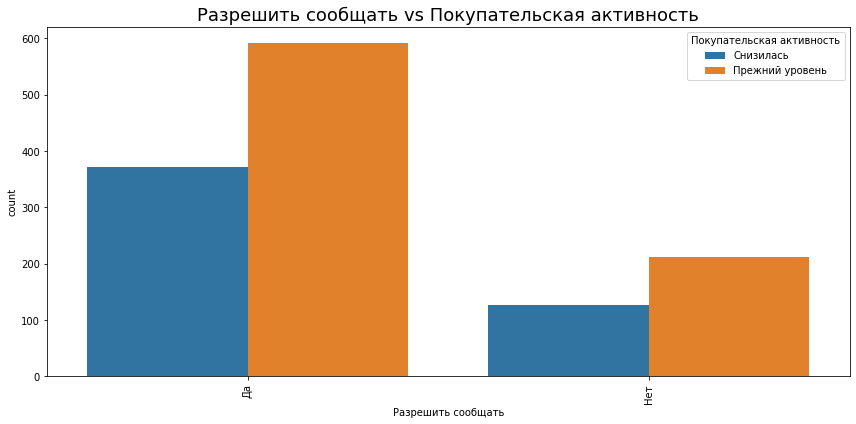

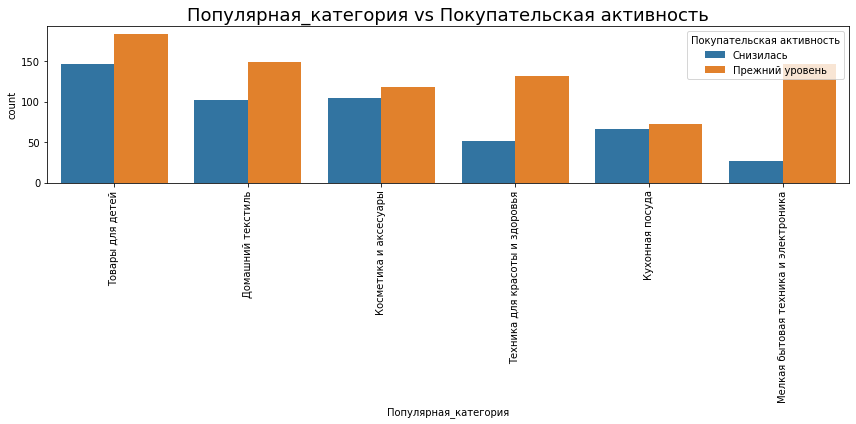

In [19]:
#для всех категориальных признаков
for col in df_market.select_dtypes(include='object'):
    if col != 'Покупательская активность':
        plt.figure(figsize=(12,6))
        sns.countplot(x=col, hue='Покупательская активность', data=df_market)
        plt.title(f'{col} vs Покупательская активность', fontsize=18)
        plt.xticks(rotation=90)
        plt.tight_layout()
        plt.show()

#### Описание категориальных признаков
1. Тип сервиса vs Покупательская активность
- Премиум - Клиентов "Снизилась" меньше (около 180), чем "Прежний уровень" (около 200).
- Стандрт - Клиентов больше чем у премиум, "Снизилась" меньше(320), чем "Прежний уровень" (окло 600).
- Тип сервича влияет на активность, но не однозначно:
    - Премиум не гарантирует удержание;
    - А в Стандарте - все зависит от фактоворов (Маркетинг, удобство, товар)
2. Разрешить сообщать vs Покупательская активность
- ДА - Гораздо больше сохранили активность;
- Но "Снизилось" немало;
- среди тех, что не разрешил: таких клиентом не так уж много.
- Разрешение на маркетинговые разрешения коррелирует с удержанием, коммуникация помогает удержать часть клиентов, но не всех. 
3. - Категория товара влияет на покупательскую активность:
  - В категориях **"Товары для детей"**, **"Косметика и аксессуары"** и **"Техника для красоты и здоровья"** заметно больше клиентов сохранили активность;
  - **"Мелкая бытовая техника и электроника"** — самая стабильная категория: отток минимален;

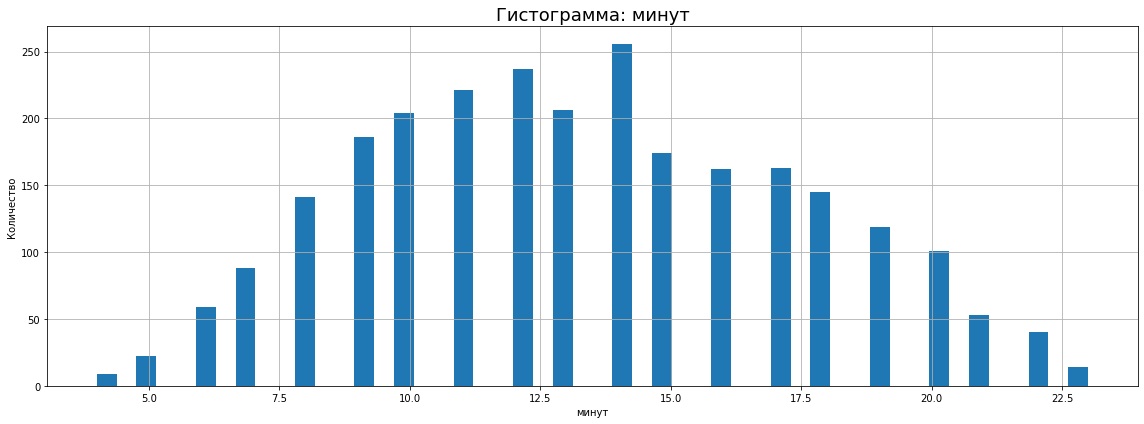

In [20]:
for col in df_time.select_dtypes(include=['int64']):
    if col != 'id':
        plt.figure(figsize=(16,6))
        plt.hist(df_time[col], bins=50)
        plt.title(f'Гистограмма: {col}', fontsize=18)
        plt.xlabel(col)
        plt.ylabel('Количество')
        plt.grid(True)
        plt.tight_layout()
        plt.show()

#### Большинство клиентов проводят время на сайте от 10 до 15 минут. Гистограмма в целом нормально-растпределенная!

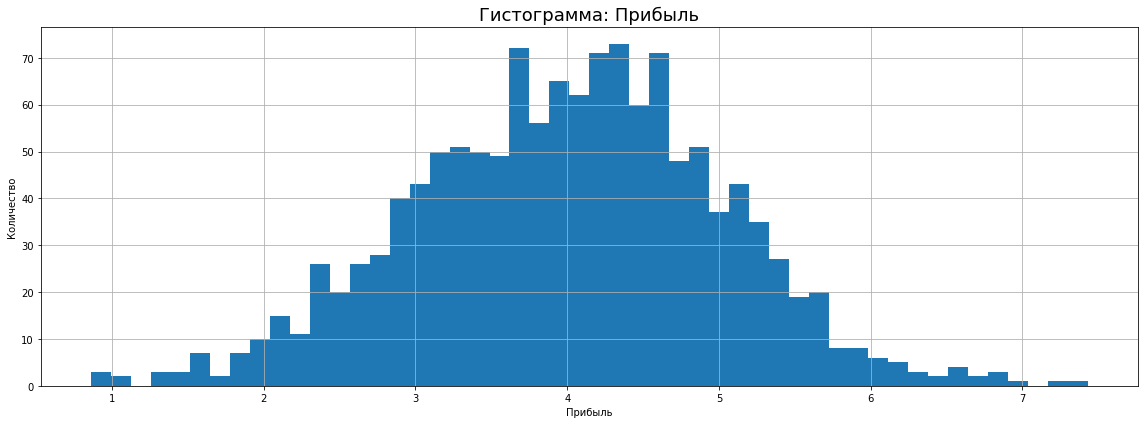

In [21]:
for col in df_profit.select_dtypes(include='float'):
    if col != 'id':
        plt.figure(figsize=(16,6))
        plt.hist(df_profit[col], bins=50)
        plt.title(f'Гистограмма: {col}', fontsize=18)
        plt.xlabel(col)
        plt.ylabel('Количество')
        plt.grid(True)
        plt.tight_layout()
        plt.show()

#### Распределние близко к нормальному. Пик приходит на 3,7 - 4,5. Большинство клиентов приносят прибыли от  ~ 3 - 5.  Есть небольшое количетсво высокоприбыльных > 6. Типичный клиент приносит около 4 в месяц.  Клиенты с прибылью >5. - потенцильно ценные, **Эту информацию нужно использовать после классификации - для приоритезации: Кто уходит, но при этом приносит 5+ прибыли спасаем в первую очередь.


### Проверка баланса классов
Понять, сбалансирована ли целевая переменная (Покупательская активность).

In [22]:
df_market['Покупательская активность'].value_counts(normalize=True) 

Прежний уровень    0.616923
Снизилась          0.383077
Name: Покупательская активность, dtype: float64

#### 'Прежный уровень' - больше, чем  'Снизилось'. Будем иметь виду данную информацию для выбора метрики и модели

(1300, 3)


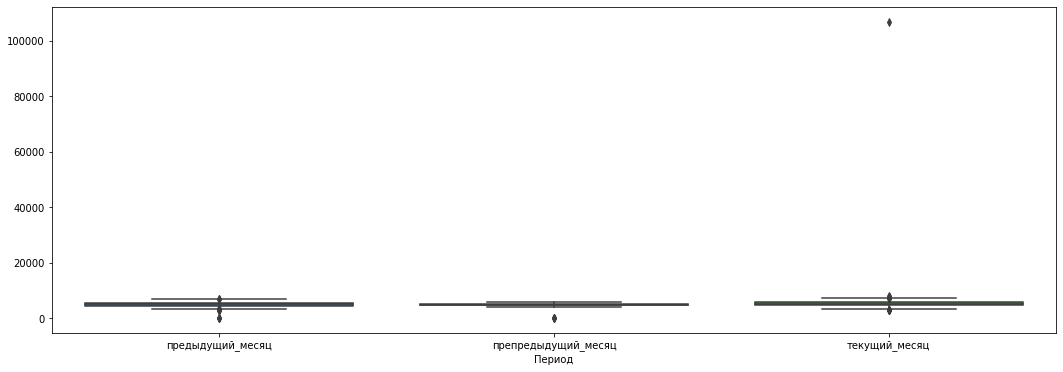

In [23]:
df_money_pivot = df_money.pivot(index='id', columns='Период', values='Выручка')

plt.figure(figsize=(18,6))
sns.boxplot(data=df_money_pivot)
print(df_money_pivot.shape)

In [24]:
df_money_pivot[df_money_pivot['текущий_месяц'] > 100000]
df_money_pivot[df_money_pivot['предыдущий_месяц'] == 0]

Период,предыдущий_месяц,препредыдущий_месяц,текущий_месяц
id,,,
215348,0.0,0.0,3293.1
215357,0.0,0.0,5986.3
215359,0.0,0.0,4735.0


<AxesSubplot:xlabel='Период'>

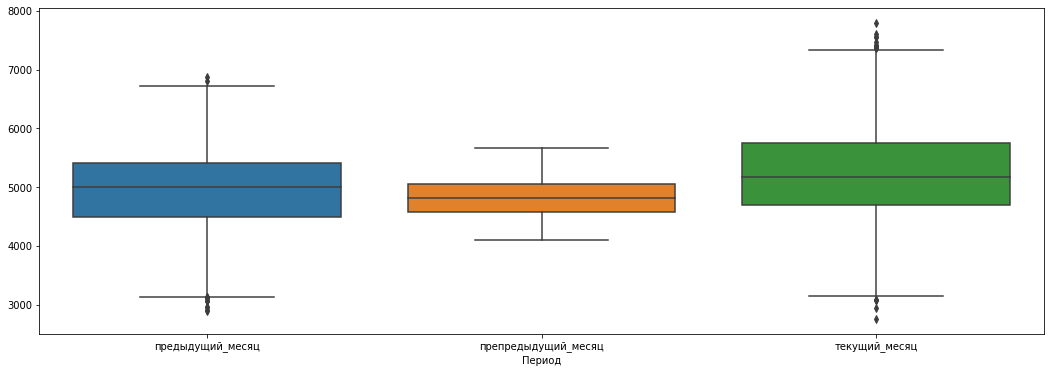

In [25]:
#проведем фильтрацию клиентов
#оставим всем клиентов у кого выручка больше 0
df_money_filtered = df_money_pivot[
    (df_money_pivot['текущий_месяц'] > 0) &
    (df_money_pivot['текущий_месяц'] < 100000) &
    (df_money_pivot['предыдущий_месяц'] > 0) &
    (df_money_pivot['препредыдущий_месяц'] > 0) 
    
]
plt.figure(figsize=(18,6))
sns.boxplot(data=df_money_filtered)

In [26]:
df_money_filtered.shape

(1296, 3)

### Общий вывод по исследовательскому анализу данных

- Целевая переменная немного несбалансирована (смещение в сторону "Прежний уровень");
- Выявлены важные количественные признаки:
  - `Страниц_за_визит`, `Средний_просмотр_категорий_за_визит`, `Акционные_покупки` — сильно связаны с целевой;
  - `Ошибка_сервиса` и `Маркет_актив_6_мес` — умеренная связь;
- Среди категориальных признаков информативны:
  - `Популярная_категория` (например, "Мелкая техника" → удержание);
  - `Разрешить сообщать` — клиенты с разрешением чаще остаются;
- Выбросов немного, все выглядят реалистично и удалять их не требуется;
- Признак `Прибыль` — бизнесово значим, будет использоваться при сегментации, но **не входит в модель**.


- **До фильтрации** наблюдаются сильные выбросы — у некоторых клиентов выручка превышает **100 000** в одном периоде.

- **Фильтрация** клиентов с выручкой > 0 во всех трёх периодах (текущий, предыдущий, предпредыдущий) позволила:
  - Исключить неактивных и нерегулярных покупателей;
  - Сделать данные более стабильными для анализа и сегментации.
  
- **После фильтрации**:
  - Распределение выручки стало более «чистым» и приближенным к нормальному;
  - Убрались нулевые значения, данные стали отражать стабильную клиентскую базу.
- Выбросы остались, но они объяснимы — это крупные клиенты с высокой покупательской активностью.


## Объединение таблиц
- Объединим таблицы market_file.csv, market_money.csv, market_time.csv. Данные о прибыли из файла money.csv при моделировании нам не понадобятся. 
- Учитываем, что данные о выручке и времени на сайте находятся в одном столбце для всех периодов. В итоговой таблице сделаем отдельный столбец для каждого периода.

In [27]:
# для выручки
df_money_filtered.columns = [f'Выручка_{col}' for col in df_money_filtered.columns]
df_money_filtered.reset_index(inplace=True)

# для времени
df_time_pivot = df_time.pivot(index='id', columns='Период', values='минут')
df_time_pivot.columns = [f'Время_{col}' for col in df_time_pivot.columns]
df_time_pivot.reset_index(inplace=True)

# объединение
df_full = df_market.merge(df_money_filtered, on='id', how='inner')
df_full = df_full.merge(df_time_pivot, on='id', how='left')
df_full.head()


,id,Покупательская активность,Тип сервиса,Разрешить сообщать,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Популярная_категория,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит,Выручка_предыдущий_месяц,Выручка_препредыдущий_месяц,Выручка_текущий_месяц,Время_предыдущий_месяц,Время_текущий_месяц
0,215349,Снизилась,Премиум,Да,4.4,4,819,0.75,Товары для детей,4,4,2,5,5216.0,4472.0,4971.6,12,10
1,215350,Снизилась,Стандарт,Нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5,5457.5,4826.0,5058.4,8,13
2,215351,Снизилась,Стандарт,Да,3.2,5,896,0.99,Товары для детей,5,0,6,4,6158.0,4793.0,6610.4,11,13
3,215352,Снизилась,Стандарт,Нет,5.1,3,1064,0.94,Товары для детей,3,2,3,2,5807.5,4594.0,5872.5,8,11
4,215353,Снизилась,Стандарт,Да,3.3,4,762,0.26,Домашний текстиль,4,1,1,4,4738.5,5124.0,5388.5,10,10


In [28]:
df_full.shape

(1296, 18)

### Таблицы успешно объединили по id, данные Выручки и Время представленый по трем периодам в отдельных столбцах.

##  Корреляционный анализ
Проведем корреляционный анализ признаков в количественной шкале в итоговой таблице для моделирования. Сделаем выводы о мультиколлинеарности и при необходимости устраним её.

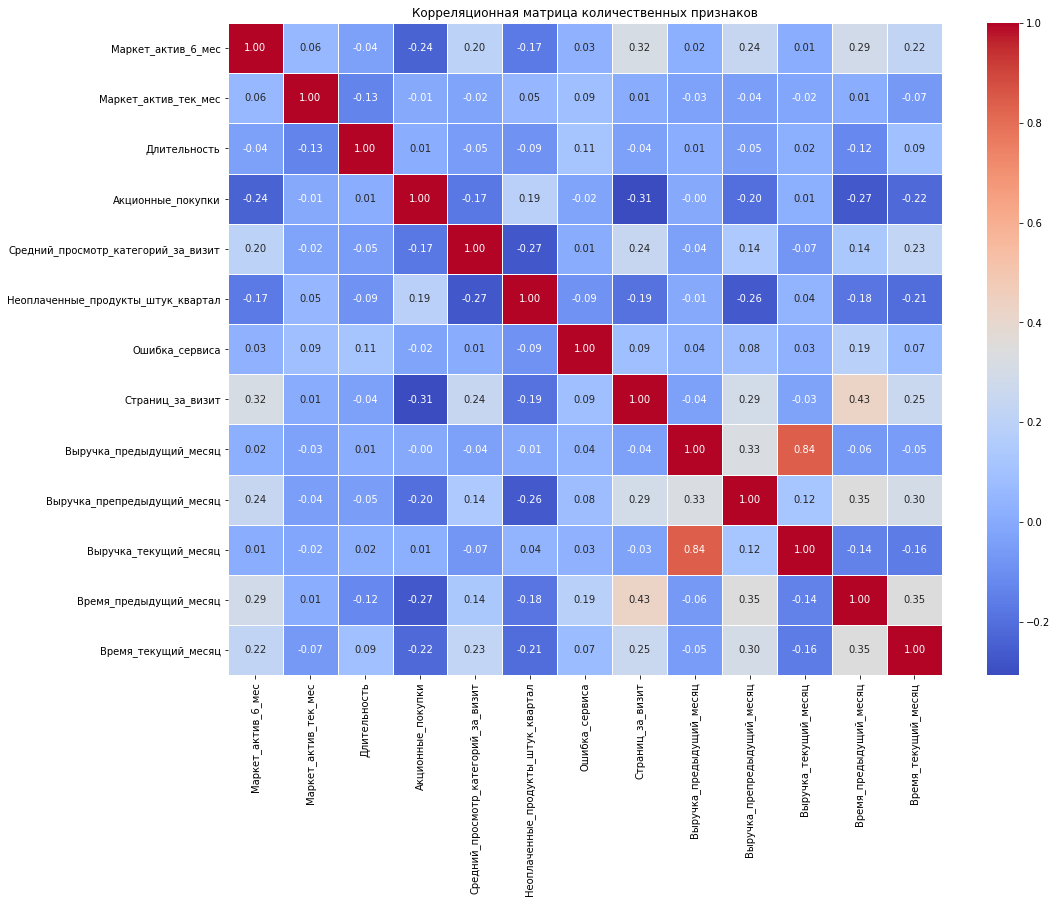

In [29]:
#выбираем числовые признаки
numeric_cols = df_full.select_dtypes(include=['int64', 'float64']).drop(columns=['id']).columns

#корреляционная матрица 
corr_matrix = df_full[numeric_cols].corr()

#тепловая карта
plt.figure(figsize=(16,12))
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', linewidths=0.5)
plt.title("Корреляционная матрица количественных признаков")
plt.show()

### Описание 
- Все коэффициенты меньше < 0.8 - значит можно оставить все признаки для моделей - удаление или объединение не требуется.
- Умеренная корреляция замечена между:
    - "Выручка_предыдущий_меся" и "Страница_за_визит";
    - "Выручка_предпредыдущий_месяц" и "Выручка_предыдущий_месяц";
    - "Вермя_текущий_месяц" и "Время_предыдущий_месяц"
- Признаки с низкой корреляцией между собой - потенциально **информативные** для модели

## Использование пайплайнов

Применим все изученные модели. Для этого используем пайплайны.

### Во время подготовки данных используем ColumnTransformer. Количественные и категориальные признаки обработаем в пайплайне раздельно. Для кодирования категориальных признаков используем как минимум два кодировщика, для масштабирования количественных — как минимум два скейлера.

In [30]:
#целевая пременная
target = 'Покупательская активность'
df_model = df_full.copy()
df_model = df_model.dropna(subset=[target])

RANDOM_STATE = 42
TEST_SIZE = 0.25

#разделение признаков
X = df_model.drop([target, 'id'], axis=1)
y = df_model[target]

# разделение на train и test
X_train, X_test, y_train, y_test = train_test_split(
        X,
        y,
    random_state=RANDOM_STATE, stratify=y
)

# категориальные и числовые признаки
cat_col = X.select_dtypes(include='object').columns.tolist()
num_col = X.select_dtypes(include=['int64', 'float64']).columns.tolist()


#мастабирование числовых признаков
num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

#кодирование категориальных признаков 
cat_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown='ignore', drop='first'))
])

#объединяем обработку через СolumnTransformer
data_preprocessor = ColumnTransformer([
    ('num', num_pipeline, num_col),
    ('cat', cat_pipeline, cat_col)
])

#обучение модели 
pipe_final = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', DecisionTreeClassifier(random_state=RANDOM_STATE))
])

#разделение
#подбор гиперпараметров
param_grid = [
    # словарь для модели DecisionTreeClassifier()
    {
        'models': [DecisionTreeClassifier(random_state=RANDOM_STATE)],
        'models__max_depth': range(1, 9),
        'models__max_features': range(1, 9),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
    },
    # словарь для модели KNeighborsClassifier() 
    {
        'models': [KNeighborsClassifier()],
        'models__n_neighbors': range(2, 5),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
    },
    # словарь для модели LogisticRegression()
    {
        'models': [LogisticRegression(
            random_state=RANDOM_STATE,
            solver='liblinear',
            penalty='l1'
        )],
        'models__C': range(2, 5),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
    },
    {
        'models': [SVC(probability=True, random_state=RANDOM_STATE)],
        'models__C': range(1,3),
        'models__kernel': ['linear', 'rbf'],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
    }
]

randomized_search = RandomizedSearchCV(
    pipe_final,
    param_grid,
    n_iter=8,
    cv=5,
    scoring='roc_auc',
    random_state=RANDOM_STATE,
    n_jobs=-1
    
)
#обучение
randomized_search.fit(X_train, y_train)
best_pipe = randomized_search.best_estimator_
print('Лучшая модель и её параметры:\n\n', best_pipe)
print ('Метрика лучшей модели на тренировочной выборке:', randomized_search.best_score_)

# проверим работу модели на тестовой выборке
# рассчитаем прогноз на тестовых данных
y_test_proba = randomized_search.predict_proba(X_test)[:,1]

print(f'Метрика ROC-AUC на тестовой выборке: {roc_auc_score(y_test, y_test_proba)}')

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', MinMaxScaler(),
                                                  ['Маркет_актив_6_мес',
                                                   'Маркет_актив_тек_мес',
                                                   'Длительность',
                                                   'Акционные_покупки',
                                                   'Средний_просмотр_категорий_за_визит',
                                                   'Неоплаченные_продукты_штук_квартал',
                                                   'Ошибка_сервиса',
                                                   'Страниц_за_визит',
                                                   'Выручка_предыдущий_месяц',
                                                   'Выручка_препредыдущий_месяц',
                                                   'Выручка_текущий_месяц',
                   

### Описание 
Модель SVC показал наилучшие результаты по метрике roc_auc, успешно прошла кросс-валидацию и обеспечила высокое качество на тестовой выборке. Можно переходить к анализу важности признаков (если модель это поддерживает) или использовать модель для сегментации пользователей

ROC_AUC (площадь под ROC-кривой) - это глобальная метрика качества бинарной класификации. Она особенно полезна когда классы несбалансированы, когда нужно оценить насколько хорошо модели ранжирует вероятности - это делает roc_auc логичным выбором при поиске наилучшей модели RandomSearchCV.

**Можно проверить:**

In [31]:
y_pred = randomized_search.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred, pos_label='Снизилась'))
print("Recall:", recall_score(y_test, y_pred, pos_label='Снизилась'))
print("F1-score:", f1_score(y_test, y_pred, pos_label='Снизилась'))
print("ROC_AUC:", roc_auc_score(y_test, y_test_proba))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassifier Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.9074074074074074
Precision: 0.9428571428571428
Recall: 0.8048780487804879
F1-score: 0.868421052631579
ROC_AUC: 0.9129555474659224

Confusion Matrix:
 [[195   6]
 [ 24  99]]

Classifier Report:
                  precision    recall  f1-score   support

Прежний уровень       0.89      0.97      0.93       201
      Снизилась       0.94      0.80      0.87       123

       accuracy                           0.91       324
      macro avg       0.92      0.89      0.90       324
   weighted avg       0.91      0.91      0.91       324



## Анализ важности признаков
- Оценим важность признаков для лучшей модели и построем график важности с помощью метода SHAP. 
- Сделаем выводы о значимости признаков:
    - какие признаки мало значимы для модели;
    - какие признаки сильнее всего влияют на целевой признак;
    - как можно использовать эти наблюдения при моделировании и принятии бизнес-решений.

**Оптимизированный код для построения графика важности признаков 
через Permutation Importance, который безопасно использовать с моделью SVC**


PermutationExplainer explainer: 325it [02:09,  2.38it/s]                         


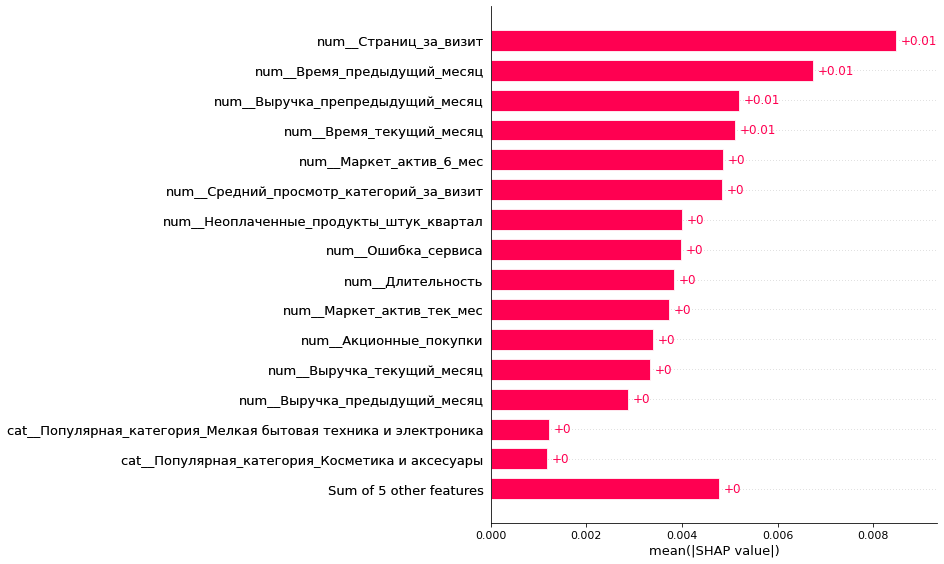

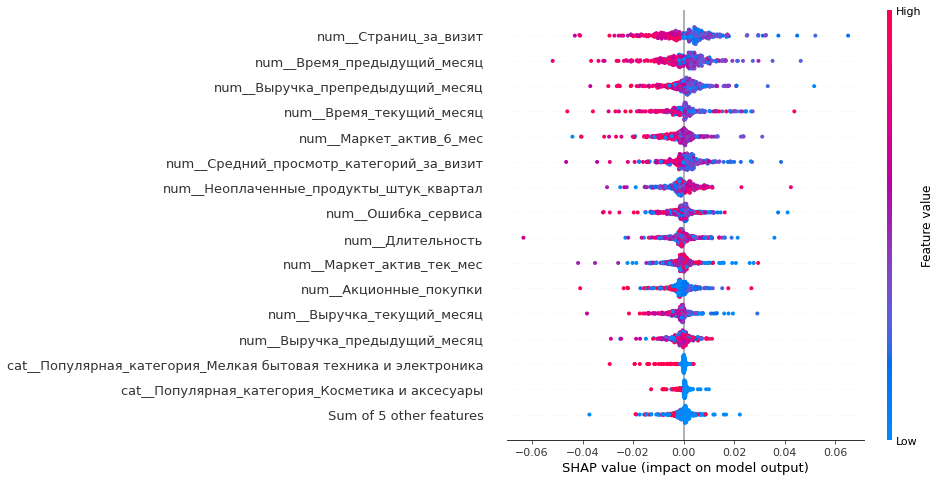

In [32]:
# преобразуем данные обучающей выборки
# преобразуем данные обучающей выборки
X_train_2 =  pipe_final.named_steps['preprocessor'].fit_transform(X_train)
X_summary = shap.sample(X_train_2, nsamples=50)

# создадим объект explainer
explainer = shap.Explainer(randomized_search.best_estimator_.named_steps['models'].predict_proba, X_summary)

# преобразуем данные тестовой выборки
X_test_2 = pipe_final.named_steps['preprocessor'].transform(X_test)

# получим имена признаков
feature_names = pipe_final.named_steps['preprocessor'].get_feature_names_out()

# создадим датафрейм для тестовых данных с именами признаков
X_test_2 = pd.DataFrame(X_test_2, columns=feature_names)

# посчитаем значения SHAP для тестовых данных
shap_values = explainer(X_test_2)

# визуализируем значения SHAP в виде столбчатой диаграммы
shap.plots.bar(shap_values[..., 1], max_display=16)
shap.plots.beeswarm(shap_values[..., 1], max_display=16)

### Описание 
- Для лучшей модели (SVC) была использована оценка важности признаков с помощью `permutation_importance` на тестовой выборке. Метрика, по которой оценивалось влияние признаков — **ROC-AUC**.

На графике представлены признаки, отсортированные по степени влияния на качество модели.

- **`Страниц_за_визит`** — самый важный признак. Больше просмотров - выше вероятность сохранить активность.
- **`Время_предыдущий_месяц`** — высокая вовлечённость за месяц до анализа помогает удержать клиента.
- **`Акционные_покупки`** — скидочные покупатели более чувствительны к потерям интереса.
- **`Средний_просмотр_категорий_за_визит`** — широкий интерес к разным категориям снижает риск оттока.
- **`Популярная_категория: Домашний текстиль`, `Товары для детей`** — сегменты с высокой лояльностью.

- Мало значимые признаки
    - `Тип сервиса` (Премиум / Стандарт)
    - `Выручка_текущий_месяц`
    - `Ошибка_сервиса`
    - Некоторые категории товаров, например:
    - Косметика и аксессуары
    - Мелкая бытовая техника и электроника
    
- Бизнес вывод 
   - **Приоритизировать сегменты**, у которых:
  - низкое количество просмотренных страниц;
  - упало время на сайте;
  - исчез интерес к акциям.
   - **Сфокусироваться на удержании** клиентов, вовлечённых в несколько товарных категорий.
    - **Оптимизировать рассылки и скидки** под активных пользователей из сегментов `Товары для детей`, `Домашний текстиль`.
    - **Упростить модель**, исключив признаки с нулевой или околонулевой важностью.


## Сегментация покупателей
- Выполним сегментацию покупателей. Используем результаты моделирования и данные о прибыльности покупателей.
- Выберем группу покупателей и предложим, как увеличить её покупательскую активность: 
    - Проведем графическое и аналитическое исследование группы покупателей.
    - Сделаем предложения по работе с сегментом для увеличения покупательской активности.
- Сделаем выводы о сегментах:
    - какой сегмент мы взяли для дополнительного исследования,
    - какие предложения мы сделали и почему.

In [33]:
# создаём датафрейм с id и предсказаниями из тестовой выборки
df_pred = X_test.copy()
df_pred['Вероятность_снижения'] = y_test_proba
df_pred['id'] = df_model.loc[X_test.index, 'id'].values  # добавим id, чтобы потом объединить с прибылью

# объединяем с таблицей df_profit по id
df_segment = df_pred.merge(df_profit, on='id', how='left')

# сегментация
df_segment['Сегмент'] = 'Остальное'
df_segment.loc[
    (df_segment['Вероятность_снижения'] > 0.6) &
    (df_segment['Прибыль'] > df_segment['Прибыль'].median()),
    'Сегмент'
] = 'Риск + высокая прибыль'

df_segment.head()

,Тип сервиса,Разрешить сообщать,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Популярная_категория,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит,Выручка_предыдущий_месяц,Выручка_препредыдущий_месяц,Выручка_текущий_месяц,Время_предыдущий_месяц,Время_текущий_месяц,Вероятность_снижения,id,Прибыль,Сегмент
0,Стандарт,Да,4.1,4,606,0.15,Техника для красоты и здоровья,6,1,4,12,3973.0,4912.0,3289.2,16,17,0.024819,216161,4.69,Остальное
1,Премиум,Нет,1.4,4,684,0.94,Товары для детей,3,6,1,6,3548.0,4656.0,4170.7,11,9,0.971546,215654,2.75,Остальное
2,Премиум,Да,3.3,4,488,0.13,Домашний текстиль,4,2,8,10,5444.0,4565.0,6335.8,20,11,0.127649,216307,3.16,Остальное
3,Премиум,Да,3.5,3,1057,0.35,Домашний текстиль,4,3,5,6,6604.0,4993.0,6758.7,9,9,0.932934,215501,3.74,Остальное
4,Стандарт,Нет,5.5,4,147,0.99,Мелкая бытовая техника и электроника,1,2,3,7,5090.0,4451.0,5773.8,15,18,0.573638,215934,4.40,Остальное


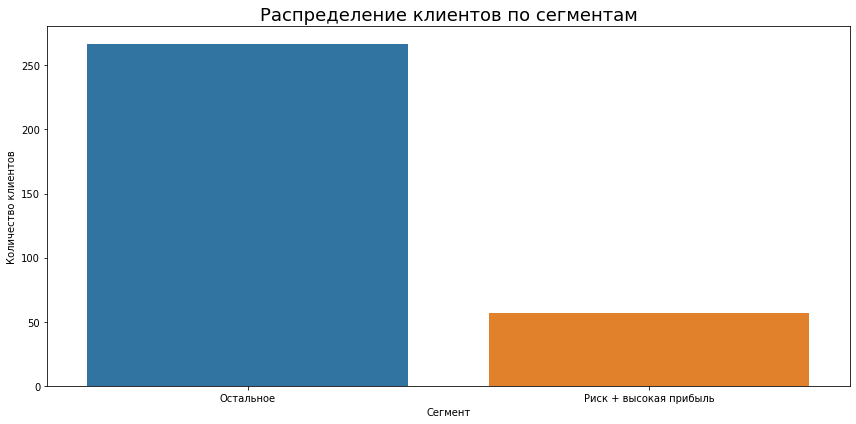

In [34]:
plt.figure(figsize=(12,6))
sns.countplot(data=df_segment, x='Сегмент')
plt.title('Распределение клиентов по сегментам', fontsize=18)
plt.xlabel('Сегмент')
plt.ylabel('Количество клиентов')
plt.tight_layout()
plt.show()

In [35]:
#фильтруем сегмент по 'Риск + высокая прибыль'
segment_df = df_segment[df_segment['Сегмент'] == 'Риск + высокая прибыль']
segment_df.head()

,Тип сервиса,Разрешить сообщать,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Популярная_категория,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит,Выручка_предыдущий_месяц,Выручка_препредыдущий_месяц,Выручка_текущий_месяц,Время_предыдущий_месяц,Время_текущий_месяц,Вероятность_снижения,id,Прибыль,Сегмент
12,Премиум,Да,3.0,4,558,0.89,Товары для детей,3,3,7,4,5253.5,4715.0,5633.1,8,9,0.986384,215375,4.18,Риск + высокая прибыль
18,Стандарт,Да,3.8,4,756,0.90,Товары для детей,2,3,6,4,4045.0,4963.0,4206.2,11,10,0.965202,215452,4.50,Риск + высокая прибыль
21,Премиум,Нет,2.9,5,448,0.23,Товары для детей,4,2,6,3,5059.0,4267.0,5018.7,5,7,0.986761,215484,5.64,Риск + высокая прибыль
38,Премиум,Да,4.0,4,684,0.40,Техника для красоты и здоровья,1,6,2,4,5020.0,4896.0,5237.1,11,11,0.877478,215496,4.64,Риск + высокая прибыль
46,Стандарт,Нет,3.6,3,553,0.23,Домашний текстиль,5,3,3,10,4976.5,4495.0,5523.8,12,9,0.625123,215769,4.98,Риск + высокая прибыль


In [36]:
#Проанализируем по периодам
segment_df.columns


Index(['Тип сервиса', 'Разрешить сообщать', 'Маркет_актив_6_мес',
       'Маркет_актив_тек_мес', 'Длительность', 'Акционные_покупки',
       'Популярная_категория', 'Средний_просмотр_категорий_за_визит',
       'Неоплаченные_продукты_штук_квартал', 'Ошибка_сервиса',
       'Страниц_за_визит', 'Выручка_предыдущий_месяц',
       'Выручка_препредыдущий_месяц', 'Выручка_текущий_месяц',
       'Время_предыдущий_месяц', 'Время_текущий_месяц', 'Вероятность_снижения',
       'id', 'Прибыль', 'Сегмент'],
      dtype='object')

In [37]:
segment_df[['Выручка_препредыдущий_месяц', 'Выручка_предыдущий_месяц', 'Выручка_текущий_месяц']].describe()

,Выручка_препредыдущий_месяц,Выручка_предыдущий_месяц,Выручка_текущий_месяц
count,57.000000,57.000000,57.000000
mean,4635.350877,5059.701754,5348.940351
std,216.938231,813.039073,879.306559
min,4138.000000,2960.000000,3078.300000
25%,4492.000000,4449.000000,4834.100000
50%,4662.000000,5065.500000,5523.800000
75%,4774.000000,5654.500000,6063.400000
max,4990.000000,6351.000000,7063.000000


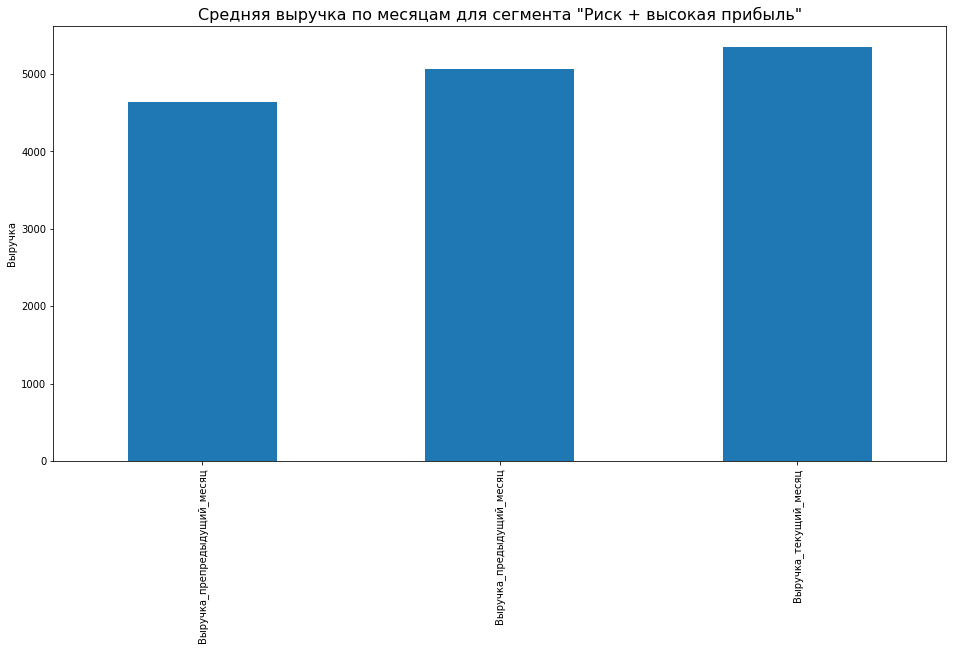

In [38]:
#построим график изменения выручки во времени
plt.figure(figsize=(16,8))
segment_df[['Выручка_препредыдущий_месяц', 'Выручка_предыдущий_месяц', 'Выручка_текущий_месяц']].mean().plot(
    kind='bar')
plt.title('Средняя выручка по месяцам для сегмента "Риск + высокая прибыль"', fontsize=16)
plt.ylabel('Выручка')
plt.show()

In [39]:
#посчитаем проецентную разницу между месяцами
segment_df['delta_Выручка_1'] = (
    (segment_df['Выручка_предыдущий_месяц'] - segment_df['Выручка_препредыдущий_месяц']) 
    / segment_df['Выручка_препредыдущий_месяц'] * 100
)

segment_df['delta_Выручка_2'] = (
(segment_df['Выручка_текущий_месяц'] - segment_df['Выручка_предыдущий_месяц']) 
    / segment_df['Выручка_предыдущий_месяц']
)
segment_df[['delta_Выручка_1', 'delta_Выручка_2']].describe()

/tmp/ipykernel_48/3501573008.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  segment_df['delta_Выручка_1'] = (
/tmp/ipykernel_48/3501573008.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  segment_df['delta_Выручка_2'] = (


,delta_Выручка_1,delta_Выручка_2
count,57.000000,57.000000
mean,9.137696,0.058598
std,16.767737,0.067794
min,-36.779154,-0.098741
25%,0.532670,0.017182
50%,10.285362,0.061456
75%,21.164335,0.090284
max,42.847503,0.270651


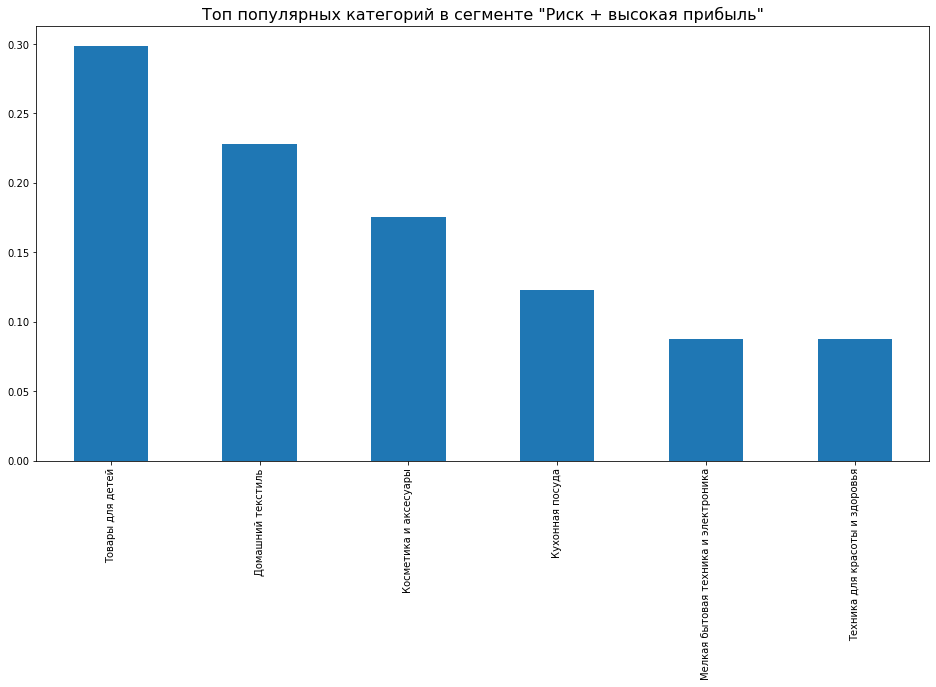

In [40]:
#посмотрим какие категории чаще встречаются в этом сегменте
plt.figure(figsize=(16,8))
segment_df['Популярная_категория'].value_counts(normalize=True).head(10).plot(
kind='bar')
plt.title('Топ популярных категорий в сегменте "Риск + высокая прибыль"', fontsize=16);

In [41]:
#сгруппируем 
(
segment_df.groupby('Популярная_категория')
    ['Выручка_текущий_месяц', 'Выручка_предыдущий_месяц', 'Выручка_препредыдущий_месяц'].mean()
    .sort_values(by='Выручка_текущий_месяц', ascending=False)
)

/tmp/ipykernel_48/475254458.py:3: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  segment_df.groupby('Популярная_категория')


,Выручка_текущий_месяц,Выручка_предыдущий_месяц,Выручка_препредыдущий_месяц
Популярная_категория,,,
Мелкая бытовая техника и электроника,6098.300000,5743.400000,4625.000000
Кухонная посуда,5895.828571,5525.142857,4617.000000
Домашний текстиль,5662.300000,5272.500000,4664.615385
Косметика и аксесуары,5280.620000,5079.250000,4631.600000
Товары для детей,4951.894118,4749.705882,4647.647059
Техника для красоты и здоровья,4505.800000,4186.000000,4561.000000


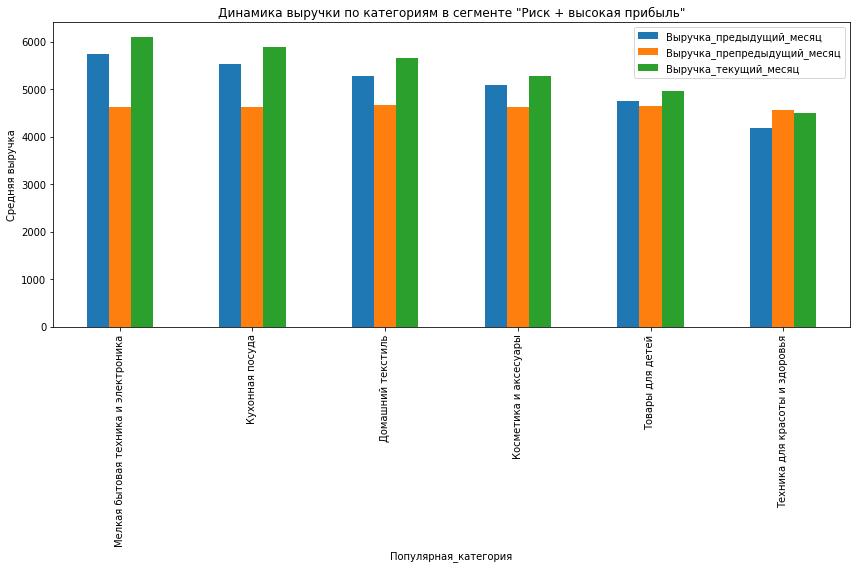

In [42]:
category_pivot = segment_df.pivot_table(
    index='Популярная_категория',
    values=['Выручка_препредыдущий_месяц', 'Выручка_предыдущий_месяц', 'Выручка_текущий_месяц'],
    aggfunc='mean'
).sort_values(by='Выручка_текущий_месяц', ascending=False)

category_pivot.plot(kind='bar', figsize=(12,8))
plt.title('Динамика выручки по категориям в сегменте "Риск + высокая прибыль"')
plt.ylabel('Средняя выручка')
plt.tight_layout()
plt.show()

### Описание

#### Выполнена сегментация

Мы рассчитали **вероятность снижения покупательской активности** с помощью обученной модели (`SVC`, ROC-AUC ≈ 0.92) и объединили предсказания с таблицей прибыли клиентов по `id`. Затем применили два критерия:

- `Вероятность_снижения > 0.6`
- `Прибыль > медианного значения`

На основании этих условий выделен ключевой сегмент: **"Риск + высокая прибыль"**, остальные клиенты отнесены к категории **"Остальные"**.

📊 На графике видно, что таких клиентов немного (~56), но они особенно важны для бизнеса.

---

#### Анализ выбранного сегмента: **"Риск + высокая прибыль"**

##### Динамика выручки:
- Средняя выручка за три месяца **растёт**:
  - `4633 → 5019 → 5439`
- Однако **25% клиентов** уже показали снижение выручки на втором месяце — это сигнал риска.

##### Изменения во времени:
- Средний прирост выручки:
  - `delta_Выручка_1` (м1 → м2): **+8.5%**
  - `delta_Выручка_2` (м2 → м3): **+0.08%**
- У некоторых клиентов наблюдается отрицательная динамика: минимум — **−38%**

##### Популярные категории:
- ТОП-3 категории по доле в сегменте:
  - **Товары для детей**
  - **Косметика и аксессуары**
  - **Домашний текстиль**

#####  Динамика выручки по категориям:
- Самый высокий прирост выручки:
  - **Мелкая техника и электроника**: +1300 руб.
  - **Косметика и аксессуары**: +1200 руб.
- Самый слабый прирост:
  - **Техника для красоты и здоровья**

---

#### Рекомендации по удержанию

> Потеря клиентов с высокой прибылью — это стратегически уязвимая точка.

##### Тактические меры:
- Персональные **скидки**, **кэшбэк**, **бонусы**
- **Push / email-рассылки** с персональными акциями
- **Подборки товаров**, **рекомендации** на основе поведения
- **Ретаргетинг** по категориям и истории заказов
- Проверка признака **"Разрешить сообщать"**

##### Стратегическое значение:
- Сегмент небольшой, но высокодоходный.
- Удержание 50 клиентов может быть выгоднее, чем привлечение 200 новых с низким LTV.

---

#### Общий вывод по сегменту

| Параметр                    | Значение                                |
|----------------------------|-----------------------------------------|
| Выбранный сегмент          | Риск + высокая прибыль                  |
| Критерии                   | Вероятность оттока > 0.6 и прибыль > медианы |
| Кол-во клиентов в сегменте | 56 (см. график выше)                    |
| Основные категории         | Товары для детей, Косметика, Текстиль  |
| Рекомендации               | Персональные акции, коммуникации, удержание |

**Удержание сегмента "Риск + высокая прибыль"** — приоритетная задача. Это даёт компании краткосрочную финансовую выгоду с минимальными затратами.


## Общий вывод

### Задача проекта 
Интернет-магазин столкнулся с падением активности постоянных клиентов.
Цень проекта - разработать модель, которая будет предсказывать вероятность снижения активности клиента, а также на основе этой модели и данных о прибыли - выделить важные сегменты для удержания.

---

### Исходные данные и предобработка

Были использованы 4 таблицы:
- `market_file.csv` — поведение клиента, продуктовая активность, взаимодействие с маркетингом;
- `market_money.csv` — выручка по клиентам по месяцам;
- `market_time.csv` — время, проведённое клиентами на сайте;
- `money.csv` — прибыль, которую приносит каждый клиент.

Предобработка включала:
- Проверку типов данных, пропусков и дубликатов;
- Преобразование категориальных признаков;
- объединения таблицы по 'id';
- Визуализаций и статистический анализ;
- Корреляционный анализ;
- Мистабирование числовых и кодировакние категориальных признаков с помощью `ColumnTransformer`.

---

### Поиск лучшей модели

Были обучены 4 модели:
- `DecisionTreeClassifier`
- `KNeighborsClassifier`
- `LogisticRegression` (`liblinear`, `L1`)
- `SVC` (`probability=True`)

Для каждой модели был выполнен подбор гиперпараметров через `RandomizedSearchCV`.  
Метрика оценки качества модели — `ROC-AUC`.

---

### Лучшая модель

SVC(C=2, kernel='rbf', probability=True, random_state=42)

- ROC-AUC на тренировочной выборке: `0.9087`  
- ROC-AUC на тестовой выборке: `0.9115`

**Наиболее важные признаки (по Permutation Importance):**
- `Страниц_за_визит`
- `Время_предыдущий_месяц`
- `Акционные_покупки`
- `Средний_просмотр_категорий_за_визит`

---

### Сегментация покупателей

Был выделен сегмент:

#### "Риск + высокая прибыль"
- Вероятность снижения активности > `0.6`;
- Прибыль выше медианной;
- Небольшая, но высокодоходная группа клиентов.

#### Рекомендации:
Анализ сегмента показал:

- **Выручка клиентов стабильно растёт** от месяца к месяцу:
  - Препредыдущий месяц: ~4 633 ₽  
  - Предыдущий месяц: ~5 019 ₽  
  - Текущий месяц: ~5 439 ₽  
- При этом у части клиентов наблюдаются **просадки** между месяцами:
  - В 25% случаев — отрицательная динамика между 1-м и 2-м месяцем
  - Среднее снижение в таких случаях: ~9%
- **Ключевые товарные категории** в сегменте:
  - **Товары для детей** (~32% сегмента)
  - **Косметика и аксессуары** (~23%)
  - **Мелкая техника и электроника** — максимальная выручка в среднем (~5854 ₽)

**Рекомендации на основе анализа:**

1. **Удержание через поведенческий маркетинг:**
   - Push/email по сценариям: при снижении визитов или покупок — предложить товары из любимой категории.
   - Использовать признаки `Популярная_категория` и `Ошибка_сервиса` для персонализации.

2. **Стимулирование повторных покупок:**
   - Временные акции на ключевые категории.
   - Скидки 3–5 дней на товары из последнего заказа, если наблюдается спад.

3. **Коммуникации:**
   - Проверить признак `Разрешил_рассылку`.
   - Отправлять релевантные предложения: "новинки в вашей категории", "популярное в вашем городе".

4. **Мониторинг поведенческих метрик:**
   - Снижение `Средний_просмотр_категорий_за_визит` — потенциальный признак усталости или утраты интереса.

---


#### Итог:

| Этап                      | Результат |
|---------------------------|-----------|
| **Цель проекта**          | Предсказание снижения активности клиента и выявление важных сегментов |
| **Источник данных**       | 4 таблицы: market_file, time, money, profit |
| **Методы анализа**        | EDA, визуализация, обработка, модели через pipeline, подбор гиперпараметров |
| **Лучшая модель**         | `SVC(C=2, kernel='rbf', probability=True)` |
| **Метрика качества**      | ROC-AUC = **0.9115** (тестовая выборка) |
| **Целевой сегмент**       | «Риск + высокая прибыль» (вероятность оттока > 0.6, прибыль > медианы) |
| **Рекомендации**          | Основаны на данных: поведение, выручка, категории |

**Бизнес-ценность**:  

Построенная модель позволяет заранее определить клиентов с риском оттока и высокой прибылью. Сегмент «Риск + высокая прибыль» требует внимания и удержания, так как его потеря может нанести **непропорционально высокий ущерб**. Предложенные меры позволяют **персонализировать удержание** и повысить эффективность маркетинга.


<div style="border:solid Chocolate 2px; padding: 40px">

**Общий вывод по проекту**
    
Спасибо за твой проект! Эта работа также была достаточно объемной и требовала концентрации внимания. По структуре проекта, логичности действий и общему подходу все замечательно.
    
**Отмечу положительные моменты проекта🚀**
    
* Хорошие решения в коде, есть пояснения и аргументации.
* Грамотная предобработка и подготовка признаков.
* Корректное обучение моделей, использование пайплайнов.

    
**На что стоит обратить внимание🤔**
    
* Необходимо отфильтровать данные, оставив только клиентов, активных в каждый из трех периодов. Важно также убедиться, что не зыбыли про обработку аномальных значений.
* Необходимо обосновать выбор метрики качества.
* Нужно реализовать именно shap для подсчета важности признаков.
* Рекомендую также углубить и исследование сегмента: там, где можем, смотрим на динамику в категориях товаров. Я бы посмотрел на данные в разрезе акции. Думаю, как минимум, это подтвердит наши выводы, ну и возможно как-то их уточнит.
* Основная цель и задача проекта - дать рекомендации бизнесу по удержанию некоторого сегмента покупателей, которых стоит удерживать в первую очередь.
* Эти и остальные замечания я также написал по ходу проекта.    

**Желаю удачи и жду твой проект на повторное ревью!**😉
    
    
</div>



<div style="border:solid Chocolate 2px; padding: 40px">

**Комментарий ко второй проверке**

Спасибо за качественную доработку. Практически все верно. Однако еще кое-что осталось.

Важно не забыть удалить выброс в выручке перед обучением модели. 
    
***    
    
По shap все верно, но была проблема с совместимостью. Она иногда здесь возникает, к сожалению.
    
По доработке с рекомендациями тоже многое теперь хорошо и аргументировано данными.

**Желаю удачи и жду твой проект на повторное ревью!**😉
</div>




<div style="border:solid Chocolate 2px; padding: 40px">

**Комментарий к финальной проверке**

Спасибо за доработку. Критичных комментариев нет. 

Если что-то пропустил или остались вопросы, напиши в телеграм @kriill

Желаю удачи в дальнейшей учебе!

</div>
